In [1]:
""" Initialize the notebook """
%matplotlib inline
import pylab as PP
import matplotlib as mpl
import netCDF4 as nc
import glob
import datetime as dt
import sys
import os
from mpl_toolkits.basemap import Basemap, cm

from matplotlib import animation

import floodfillsearch.cFloodFillSearch as flood
import calculate_pressure_integral as vint

import numpy as np

import warnings
warnings.filterwarnings('ignore')


#Set the default font for plots
font = { 'family' : 'sans-serif', \
         'size' : '15', \
         'weight' : 'bold'}
mpl.rc('font', **font)
mpl.rc('axes', labelweight = 'bold') # needed for bold axis labels in more recent version of matplotlib

# turn on html5 animation by default
mpl.rc('animation', html='html5')

import os; print("{}:{}".format('cori',os.getcwd()))

cori:/global/u2/a/amahesh/climdeeplearn/climdeeplearn/ar_detection


In [3]:
filepath = "/global/cscratch1/sd/mwehner/CAM5-1-0.25degree_All-Hist_est1_v3_run2/run/h2/CAM5-1-0.25degree_All-Hist_est1_v3_run2.cam.h2.2015-12-31-00000.nc"

with nc.Dataset(filepath) as fin:
    
    TMQ = fin.variables['TMQ'][:][:][0:1, :, :]
    U850 = fin.variables['U850'][:][0:1, :, :]
    V850 = fin.variables['V850'][:][0:1, :, :]
    QREFHT = fin.variables['QREFHT'][:][0:1, :, :]
    lats = fin.variables['lat'][:]
    lons = fin.variables['lon'][:]



In [4]:
IVT_u = U850 * QREFHT
IVT_v = V850 * QREFHT
IVT = np.sqrt(IVT_u**2 + IVT_v**2)
IVT.shape

(1, 768, 1152)

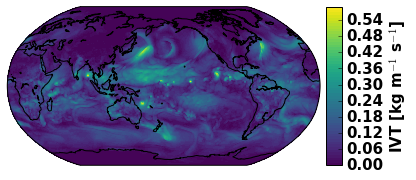

In [5]:
my_map = Basemap(projection='robin', llcrnrlat=min(lats), lon_0=180,
                 llcrnrlon=min(lons), urcrnrlat=max(lats), urcrnrlon=max(lons), resolution = 'c')
 
lon2d,lat2d = np.meshgrid(lons,lats)
x_map,y_map = my_map(lon2d,lat2d)
my_map.drawcoastlines(color="black")
my_map.contourf(x_map,y_map,IVT[0],64,cmap='viridis')
my_map.colorbar(label='IVT [kg m$^{-1}$ s$^{-1}$]')

In [62]:
""" Calculate IVT anomalies"""
# calculate the X-percentile anomalies for each timestep
IVT_time_percentile = 95
IVT_threshold = np.percentile(IVT,IVT_time_percentile,axis=(1,2))[:,np.newaxis,np.newaxis]

# damp anomalies to 0 near the tropics
sigma_lat = 10 # degrees
gaussian_band = 1 - np.exp(-lat2d**2/(2*sigma_lat**2))

# calculate IVT anomalies
IVT_anomaly = IVT*gaussian_band[np.newaxis,...] - IVT_threshold

In [63]:
""" Run flood fill search """

ivt_blobs = flood.floodFillSearch(IVT_anomaly[0])

In [73]:
print(len(lons))
print(IVT_anomaly[0].shape)

1152
(768, 1152)


In [55]:
""" Create an IVT blob array """

indrand = np.random.choice(10000,len(ivt_blobs))

ivt_blob_random_array = np.zeros(IVT[0].shape)

for i, blob in zip(indrand, ivt_blobs):
    
    ivt_blob_random_array[blob] = i + 1
    
ivt_blob_random_array = np.ma.masked_less_equal(ivt_blob_random_array,0)

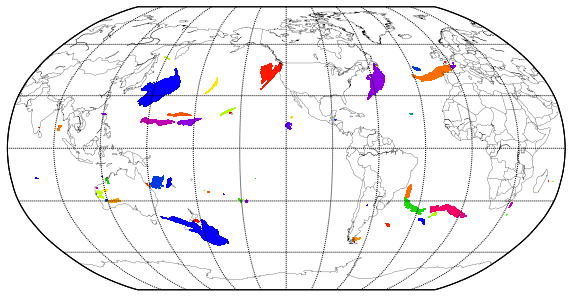

In [71]:
""" Plot IVT anomaly blobs for the first timestep """

fig,ax = PP.subplots(figsize=(10,6))

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='robin',lon_0=-120,resolution='c',ax=ax)
# draw coastlines, country boundaries, fill continents.
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
# draw the edge of the map projection region (the projection limb)
m.drawmapboundary()
# draw lat/lon grid lines every 30 degrees.
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
# compute native map projection coordinates of lat/lon grid.
lon2d,lat2d = np.meshgrid(lon,lat)
x, y = m(lon2d*180./np.pi, lat2d*180./np.pi)
# contour data over the map.
#cs = m.contourf(lon2d,lat2d,ivt_blob_random_array[0,...],64,latlon=True,cmap='prism')
cs = m.contourf(lon2d,lat2d,ivt_blob_random_array,64,latlon=True,cmap='prism')
#fig.colorbar(cs,ax=ax,label='IVT [kg m$^{-1}$ s$^{-1}$]')
PP.show()

In [58]:
ivt_blob_random_array.shape

(768, 1152)

In [22]:
""" Calculate TMQ anomalies"""
# calculate the X-percentile anomalies for each timestep
#TMQ_time_percentile = 85
#TMQ_threshold = np.percentile(TMQ,TMQ_time_percentile,axis=(1,2))[:,np.newaxis,np.newaxis]
TMQ_threshold = 20

# damp anomalies to 0 near the tropics
sigma_lat = 10 # degrees
gaussian_band = 1 - np.exp(-lat2d**2/(2*sigma_lat**2))

# calculate TMQ anomalies
TMQ_anomaly = TMQ*gaussian_band[np.newaxis,...] - TMQ_threshold

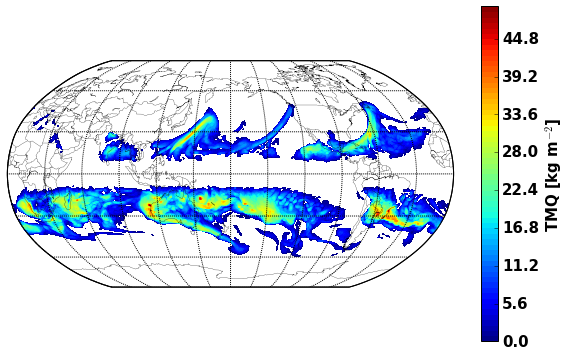

In [23]:
""" Plot IVT anomaly for the first timestep """
TMQ_anomaly_plot = np.ma.masked_less(TMQ_anomaly,0)

fig,ax = PP.subplots(figsize=(10,6))

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='robin',lon_0=0.5*(lon[0]+lon[-1]),resolution='c',ax=ax)
# draw coastlines, country boundaries, fill continents.
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
# draw the edge of the map projection region (the projection limb)
m.drawmapboundary()
# draw lat/lon grid lines every 30 degrees.
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
# compute native map projection coordinates of lat/lon grid.
lon2d,lat2d = np.meshgrid(lon,lat)
x, y = m(lon2d*180./np.pi, lat2d*180./np.pi)
# contour data over the map.
cs = m.contourf(lon2d,lat2d,TMQ_anomaly_plot[0,...],64,latlon=True)

fig.colorbar(cs,ax=ax,label='TMQ [kg m$^{-2}$]')
PP.show()

In [20]:
tmq_blobs = flood.floodFillSearch(TMQ_anomaly, wrapDimensions=[2])

(array([0, 0, 0, ..., 0, 0, 0]),
 array([130, 131, 130, ..., 341, 340, 339]),
 array([783, 783, 784, ..., 923, 922, 921]))

In [17]:
""" Create an TMQ blob array """

indrand = np.random.choice(10000,len(tmq_blobs))

tmq_blob_random_array = np.zeros(TMQ.shape)

for i, blob in zip(indrand, tmq_blobs):
    
    tmq_blob_random_array[blob] = i + 1
    
tmq_blob_random_array = np.ma.masked_less_equal(tmq_blob_random_array,0)

IndexError: too many indices for array

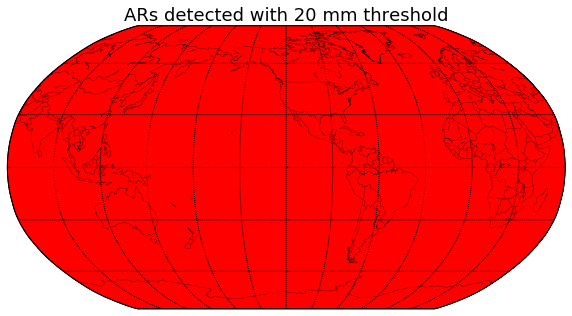

In [13]:
""" Plot TMQ anomaly blobs for the first timestep """

fig,ax = PP.subplots(figsize=(10,6))

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='robin',lon_0=-120,resolution='c',ax=ax)
# draw coastlines, country boundaries, fill continents.
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
# draw the edge of the map projection region (the projection limb)
m.drawmapboundary()
# draw lat/lon grid lines every 30 degrees.
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
# compute native map projection coordinates of lat/lon grid.
lon2d,lat2d = np.meshgrid(lon,lat)
x, y = m(lon2d*180./np.pi, lat2d*180./np.pi)
# contour data over the map.
cs = m.contourf(lon2d,lat2d,tmq_blob_random_array,64,latlon=True,cmap='prism')
PP.title("ARs detected with 20 mm threshold")

#fig.colorbar(cs,ax=ax,label='IVT [kg m$^{-1}$ s$^{-1}$]')
PP.show()